In [1]:
import os
import json 

# Reference 

Data visualization and preprocessing from here:

https://www.kaggle.com/code/kevin114514/brain-tumor-unet-zoo/notebook

# Data Visualization


In [2]:
with open('./valid/_annotations.coco.json','r') as file:
    data = json.load(file)

for img in data['images'][:10]:
    print(img['file_name'])

1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg
2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg
1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg
2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg
2647_jpg.rf.5ba404374f2d670f04a2d1367c77c039.jpg
1511_jpg.rf.5c02bb67a267960293c9e8393c2d9380.jpg
1018_jpg.rf.5c6fcb4480745ff7c60c7305781913ab.jpg
1694_jpg.rf.5c8d647ce366cbd41426af5217863bd4.jpg
2824_jpg.rf.5ca7452639b345dfd0206a58531b6910.jpg


In [3]:
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [4]:
# with open('./valid/_annotations.coco.json','r') as file:
#     data = json.load(file)

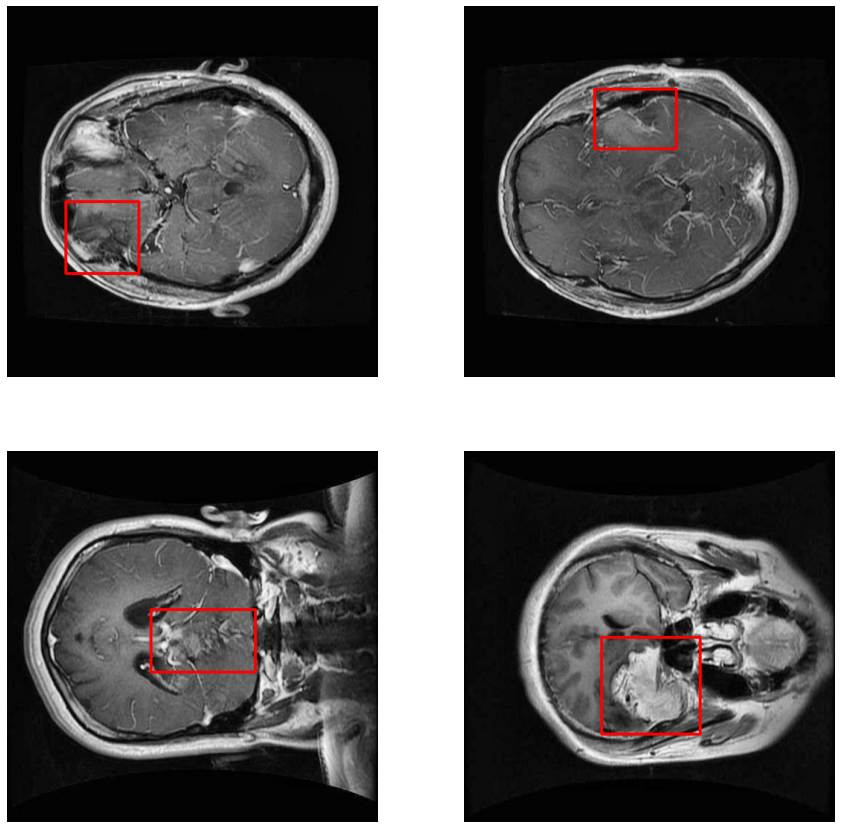

In [5]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import numpy as np
import random 

def display_masks(image_names, data):
    fig , ax = plt.subplots(2,2,figsize = (15,15))
    for i, img_path in enumerate(image_names):
        draw_image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        points_list = img_annotations[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1,1,2))
        # Draw polygon
        cv2.polylines(draw_image,[points],True,(0,0,255),3)
        
        # Display the image
        ax[i//2, i%2].imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

        
#Loading the data for visualization part
with open('./valid/_annotations.coco.json','r') as file:
    annotations = json.load(file)
#get all the image files
imge_dir = "./valid"
all_image_files = [os.path.join(imge_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files,4)
#call the draw mask function
display_masks(random_image_files,annotations)

In [6]:
#Function to create binary mask out from the json format
import skimage.draw
import tifffile
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    object_number = 1
    printed_masks = 0  # Counter for the number of printed masks
    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            for seg_idx, seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                # Create a mask for each segmentation
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  # Set the pixel values to 255 for the polygon
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached

In [7]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)

In [8]:
original_image_dir = './test'  # Where your original images are stored
json_file = './test/_annotations.coco.json'
mask_output_folder = './working/test2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = './working/test2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = './train'  # Where your original images are stored
json_file = './train/_annotations.coco.json'
mask_output_folder = './working/train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = './working/train2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = './valid'  # Where your original images are stored
json_file = './valid/_annotations.coco.json'
mask_output_folder = './working/valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = './working/valid2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)


In [9]:
def compare_folders_and_delete(folder1_path, folder2_path):
    folder1_items = os.listdir(folder1_path)
    folder2_items = os.listdir(folder2_path)

    for item1 in folder1_items:
        found = False
        for item2 in folder2_items:
            if item1[:4] == item2[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1_path, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    for item2 in folder2_items:
        found = False
        for item1 in folder1_items:
            if item2[:4] == item1[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2_path, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")

# Example usage:
folder1_path = "./working/train2/images"
folder2_path = "./working/train2/masks"
compare_folders_and_delete(folder1_path, folder2_path)

Corresponding item for 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


# Custom Dataset creation

In [10]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "./working/train2" 
valid_path = "./working/valid2"
test_path = "./working/test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Create datasets
train_dataset = CustomDataset_general(train_path, transform=image_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform)
test_dataset = CustomDataset_general(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([16, 1, 224, 224]),
 torch.Size([16, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [12]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.optim import lr_scheduler
from U_net import UNet
from U_net_optimize import UNet_op
from torchvision.transforms import ToTensor
import torch.optim as optim

In [13]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


In [14]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        dice_loss = 1 - dice_coeff
        return dice_loss

class CombinedDiceCELoss(nn.Module):
    def __init__(self, weight=None, reduction='mean'):
        super(CombinedDiceCELoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.BCEWithLogitsLoss(weight=weight, reduction=reduction)

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        ce_loss = self.ce_loss(inputs, targets)
        combined_loss = dice_loss + ce_loss
        return combined_loss


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = UNet(num_classes=1).to(device)
model1.apply(init_weights)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = CombinedDiceCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

n_epochs = 15
print(device)

cuda


In [16]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    track_loss = 0

    for i, (images, labels) in enumerate(dataloader):
        # images, labels = images.to(mps_device), labels.to(mps_device)
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients before the forward pass
        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)
        
        # Compute the loss
        loss = loss_fn(predictions, labels)
        track_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if i % 100 == 0:  # Adjust this to control how often you want to print
            print(f"Batch: {i+1}/{len(dataloader)}, Loss: {track_loss / (i + 1)}")
    
    epoch_loss = track_loss / len(dataloader)
    return epoch_loss

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"No improvement in validation loss for {self.counter} consecutive epochs.")

            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")


In [18]:
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

In [19]:
def dice_coefficient(predicted, target):
    smooth = 1e-5
    predicted_flat = predicted.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (predicted_flat * target_flat).sum()
    return (2. * intersection + smooth) / (predicted_flat.sum() + target_flat.sum() + smooth)


In [20]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_dice_coefficient = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * images.size(0)
            
            # Assuming your outputs and labels are already in the correct format
            # If not, you might need to apply a sigmoid or softmax and a threshold
            dice_coeff = dice_coefficient(torch.sigmoid(outputs), labels)
            total_dice_coefficient += dice_coeff.item() * images.size(0)
            total_samples += images.size(0)
    
    average_loss = total_loss / total_samples
    average_dice_coefficient = total_dice_coefficient / total_samples
    return average_loss, average_dice_coefficient

In [21]:
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    train_epoch_loss = train_one_epoch(train_loader, model1, loss_fn, optimizer, device)
    
    val_loss, val_dice = evaluate(model1, valid_loader, loss_fn, device)
    print(f"Training loss: {train_epoch_loss}, Validation Loss: {val_loss}, Validation Dice: {val_dice}")
    
    early_stopping(val_loss)  # Or consider using val_dice for early stopping
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("--------------------------------------------------")


Epoch 1/15
Batch: 1/94, Loss: 1.7521032094955444
Training loss: 1.1178841508449393, Validation Loss: 0.9393451169376329, Validation Dice: 0.2205055114272591
--------------------------------------------------
Epoch 2/15
Batch: 1/94, Loss: 0.8826855421066284
Training loss: 0.8629322375388856, Validation Loss: 0.8606328803064662, Validation Dice: 0.27666446139345635
--------------------------------------------------
Epoch 3/15
Batch: 1/94, Loss: 0.8272738456726074
Training loss: 0.769746149474002, Validation Loss: 0.7865245047704879, Validation Dice: 0.3387147934981437
--------------------------------------------------
Epoch 4/15
Batch: 1/94, Loss: 0.7265118360519409
Training loss: 0.6810757790474181, Validation Loss: 0.7253734367988605, Validation Dice: 0.3912309249103208
--------------------------------------------------
Epoch 5/15
Batch: 1/94, Loss: 0.6707810759544373
Training loss: 0.6103270323352611, Validation Loss: 0.7086290014095795, Validation Dice: 0.40604026973386464
----------

In [22]:
model2 = UNet_op(num_classes=1).to(device)
model2.apply(init_weights)
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

n_epochs = 15
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    train_epoch_loss = train_one_epoch(train_loader, model2, loss_fn, optimizer, device)
    
    val_loss, val_dice = evaluate(model2, valid_loader, loss_fn, device)
    print(f"Training loss: {train_epoch_loss}, Validation Loss: {val_loss}, Validation Dice: {val_dice}")
    
    early_stopping(val_loss)  # Or consider using val_dice for early stopping
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("--------------------------------------------------")

Epoch 1/15
Batch: 1/94, Loss: 1.6555867195129395
Training loss: 1.0912633189495573, Validation Loss: 0.9350681235462358, Validation Dice: 0.2484125021523807
--------------------------------------------------
Epoch 2/15
Batch: 1/94, Loss: 0.9188952445983887
Training loss: 0.818260944904165, Validation Loss: 0.7658705522408297, Validation Dice: 0.35767448948813485
--------------------------------------------------
Epoch 3/15
Batch: 1/94, Loss: 0.7896803021430969
Training loss: 0.7088498517553857, Validation Loss: 0.6888514511235111, Validation Dice: 0.4224596909292928
--------------------------------------------------
Epoch 4/15
Batch: 1/94, Loss: 0.5483870506286621
Training loss: 0.6242308844911292, Validation Loss: 0.6574197842246725, Validation Dice: 0.4444505726540839
--------------------------------------------------
Epoch 5/15
Batch: 1/94, Loss: 0.6180530190467834
Training loss: 0.5541092632932866, Validation Loss: 0.6301961857955772, Validation Dice: 0.46774420961911306
----------

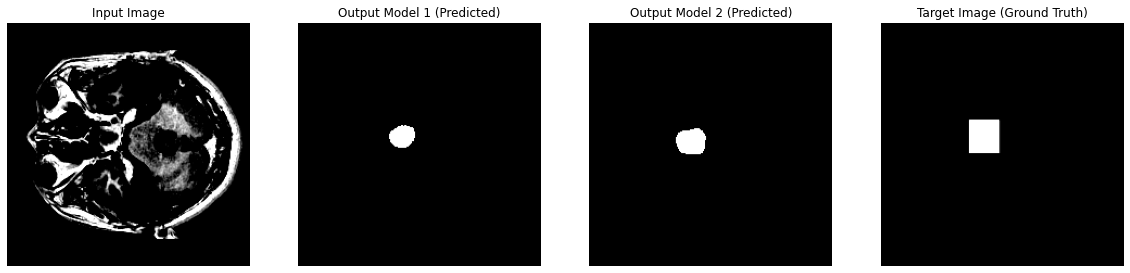

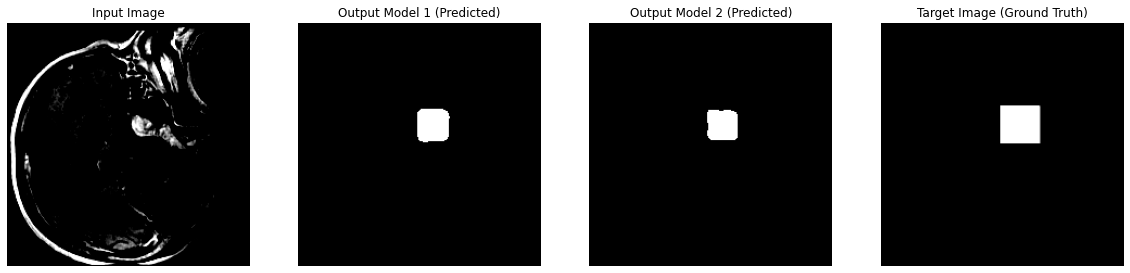

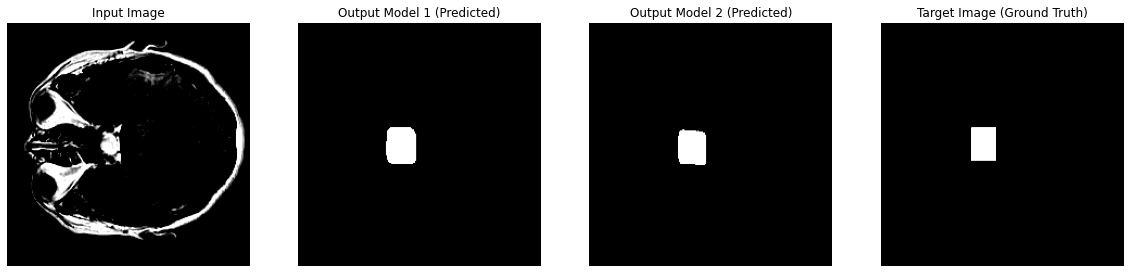

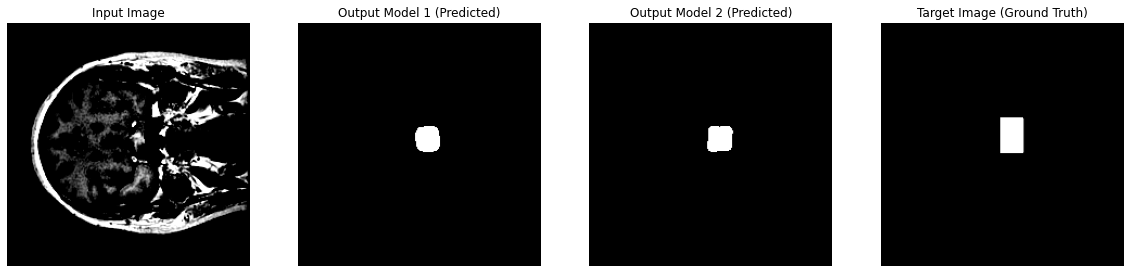

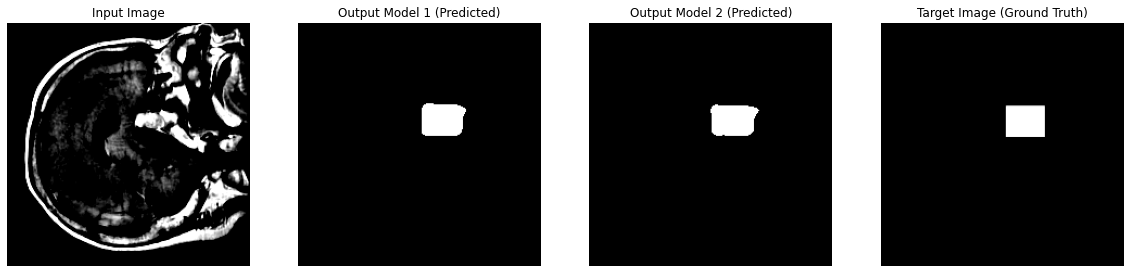

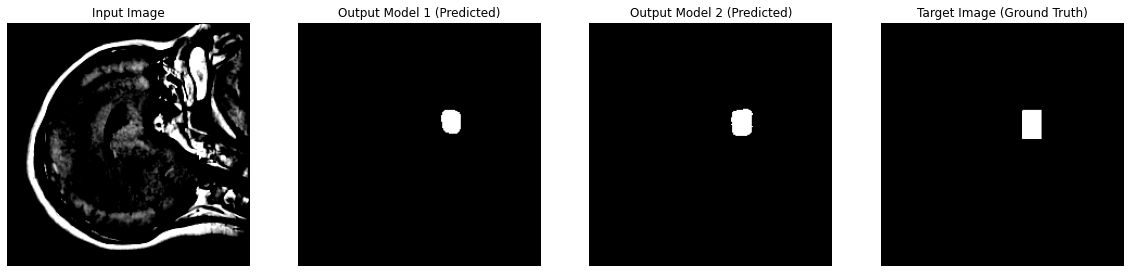

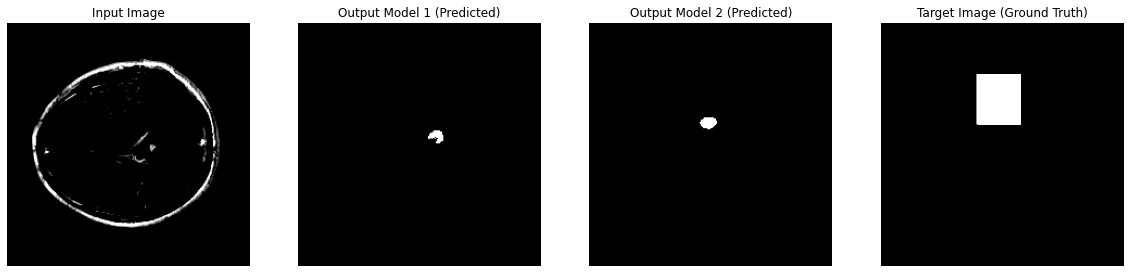

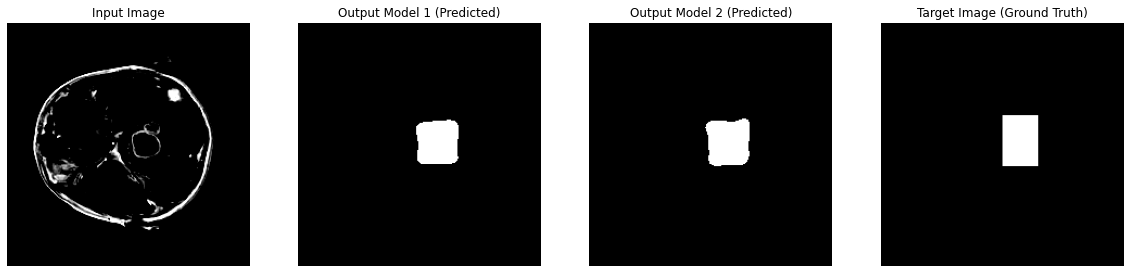

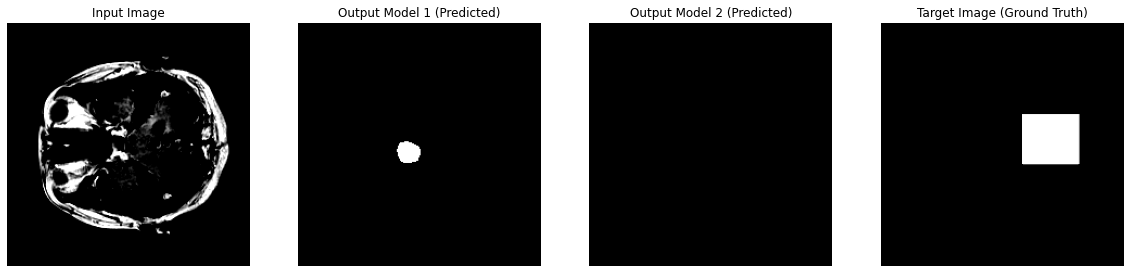

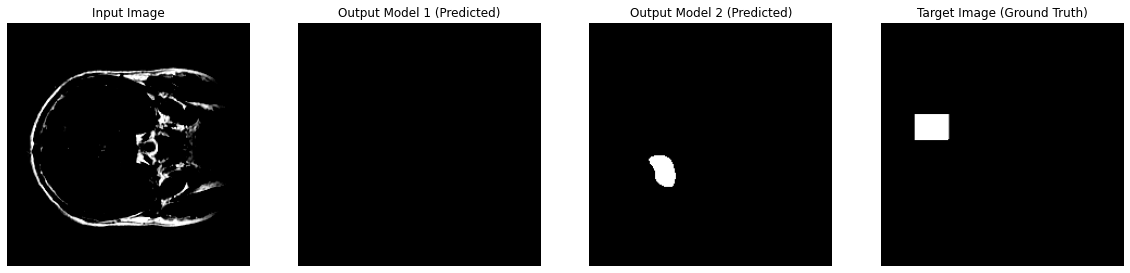

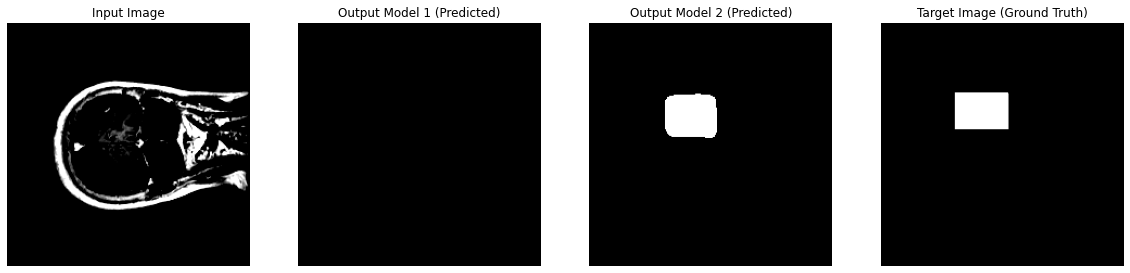

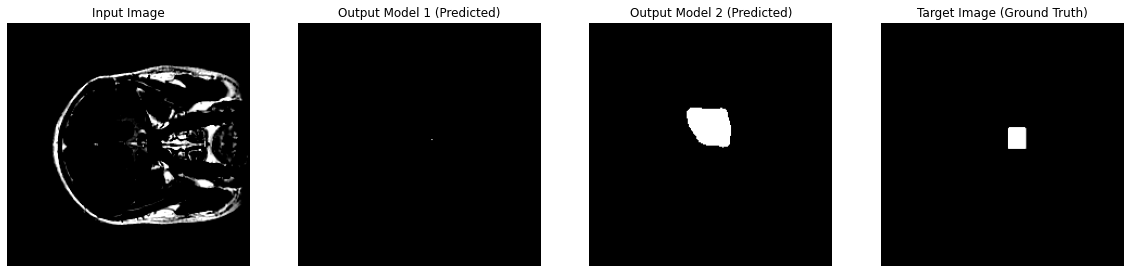

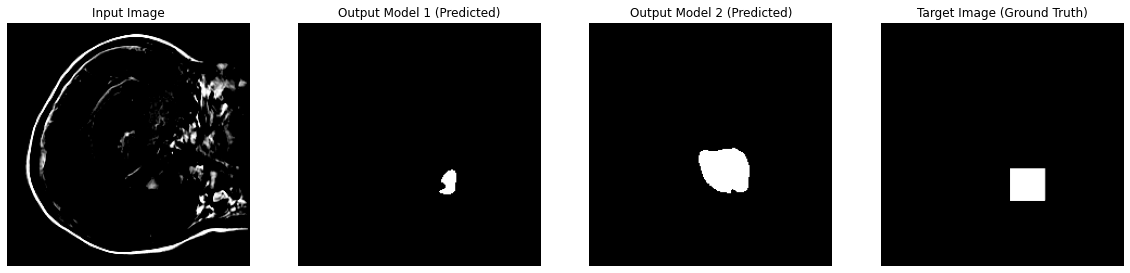

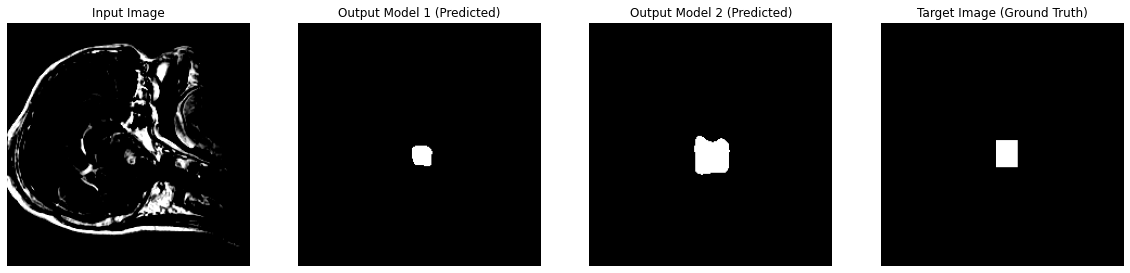

In [23]:
def visualize_comparisons(input_image, output_image_model1, output_image_model2, target_image):
    # Move tensors to CPU memory if they are on CUDA devices
    input_image = input_image.cpu()
    output_image_model1 = output_image_model1.cpu()
    output_image_model2 = output_image_model2.cpu()
    target_image = target_image.cpu()

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjusted for four subplots

    # Plot input image
    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Plot output image from model 1 (predicted binary mask)
    axes[1].imshow(output_image_model1.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Output Model 1 (Predicted)')
    axes[1].axis('off')

    # Plot output image from model 2 (predicted binary mask)
    axes[2].imshow(output_image_model2.squeeze().numpy(), cmap='gray')
    axes[2].set_title('Output Model 2 (Predicted)')
    axes[2].axis('off')

    # Plot target image (ground truth binary mask)
    axes[3].imshow(target_image.squeeze().numpy(), cmap='gray')
    axes[3].set_title('Target Image (Ground Truth)')
    axes[3].axis('off')

    plt.show()
    fig.savefig("comparison_output.png")

# Example usage within an inference loop
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        # Get predictions from both models
        y_pred_logits_model1 = model1(X)
        y_pred_logits_model2 = model2(X)
        
        # Convert logits to binary predictions for both models
        y_pred_binary_model1 = (y_pred_logits_model1 > 0.5).float()
        y_pred_binary_model2 = (y_pred_logits_model2 > 0.5).float()

        # Visualize input, outputs from both models, and ground truth for the first sample in the batch
        visualize_comparisons(X[0], y_pred_binary_model1[0], y_pred_binary_model2[0], y[0])
